In [1]:
import xarray as xr
from pathlib import Path
import glob

In [2]:
def create_synthetic_data(n_files=10, data_dir='data/air'):
    """
    Create netCDF files
    
    Parameters
    ---------
    n_files : int
         Total number of files that will be created
    data_dir : str
         Directory to use when creating the netCDF files
         
    Returns
    -------
    filenames : list
       List of filepaths for the created netCDF files
    """
    ds = xr.tutorial.open_dataset('air_temperature')
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)
    filenames = [f'{data_dir}/air_temperature_{i}.nc' for i in range(n_files)]
    for filename in filenames:
        ds.to_netcdf(filename)
    return filenames

In [3]:
filepaths = create_synthetic_data()

<ipython-input-2-db76fe16c76b>:22: SerializationWarning: saving variable air with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf(filename)


In [5]:
filepaths

['data/air/air_temperature_0.nc',
 'data/air/air_temperature_1.nc',
 'data/air/air_temperature_2.nc',
 'data/air/air_temperature_3.nc',
 'data/air/air_temperature_4.nc',
 'data/air/air_temperature_5.nc',
 'data/air/air_temperature_6.nc',
 'data/air/air_temperature_7.nc',
 'data/air/air_temperature_8.nc',
 'data/air/air_temperature_9.nc']

Let's create a tarbar for the created netCDF files

In [6]:
!tar Pcvf data/air_dataset.tar data/air

a data/air
a data/air/air_temperature_9.nc
a data/air/air_temperature_8.nc
a data/air/air_temperature_3.nc
a data/air/air_temperature_7.nc
a data/air/air_temperature_6.nc
a data/air/air_temperature_2.nc
a data/air/air_temperature_5.nc
a data/air/air_temperature_1.nc
a data/air/air_temperature_0.nc
a data/air/air_temperature_4.nc


## ratarmount

We will use [ratarmount](https://github.com/mxmlnkn/ratarmount) to create an index file with file names, ownership, permission flags, and offset information to be stored at the TAR file's location. Once the index is created, ratarmount then offers a FUSE mount integration for easy access to the files.

In [7]:
!ratarmount --recreate-index data/air_dataset.tar mounted_air_dataset

Creating offset dictionary for /Users/abanihi/devel/ncar/xtar/notebooks/data/air_dataset.tar ...
Creating new SQLite index database at /Users/abanihi/devel/ncar/xtar/notebooks/data/air_dataset.tar.index.sqlite
Creating offset dictionary for /Users/abanihi/devel/ncar/xtar/notebooks/data/air_dataset.tar took 0.01s
Writing out TAR index to /Users/abanihi/devel/ncar/xtar/notebooks/data/air_dataset.tar.index.sqlite took 0s and is sized 24576 B


In [8]:
mounted_dir = Path("mounted_air_dataset/data/air/")
list(mounted_dir.iterdir())

[PosixPath('mounted_air_dataset/data/air/air_temperature_0.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_1.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_2.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_3.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_4.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_5.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_6.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_7.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_8.nc'),
 PosixPath('mounted_air_dataset/data/air/air_temperature_9.nc')]

## Benchmarks

In [21]:
from dask.distributed import performance_report, Client

In [22]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54988 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


## Original netCDF files

In [23]:
ds = xr.open_mfdataset("data/air/*.nc", combine='nested', concat_dim='member_id')
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, member_id: 10, time: 2920)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Dimensions without coordinates: member_id
Data variables:
    air      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 2920, 25, 53), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

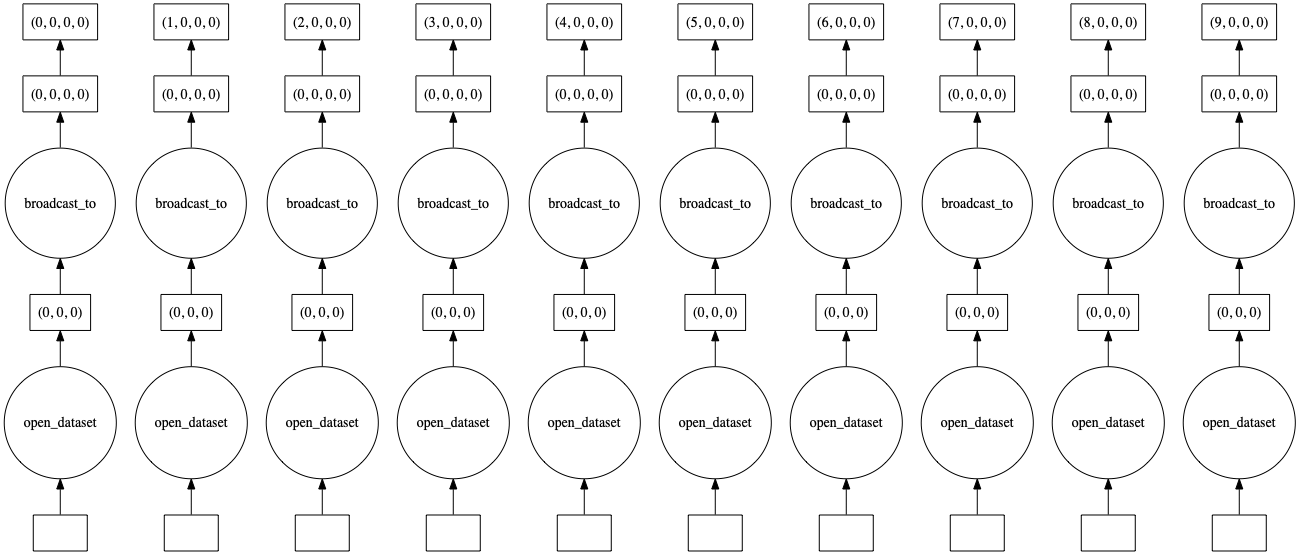

In [24]:
ds.air.data.visualize()

## Mounted netCDF files from the tar archive

In [25]:
dset = xr.open_mfdataset("mounted_air_dataset/data/air/*.nc", combine='nested', concat_dim='member_id')
dset

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, member_id: 10, time: 2920)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Dimensions without coordinates: member_id
Data variables:
    air      (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 2920, 25, 53), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

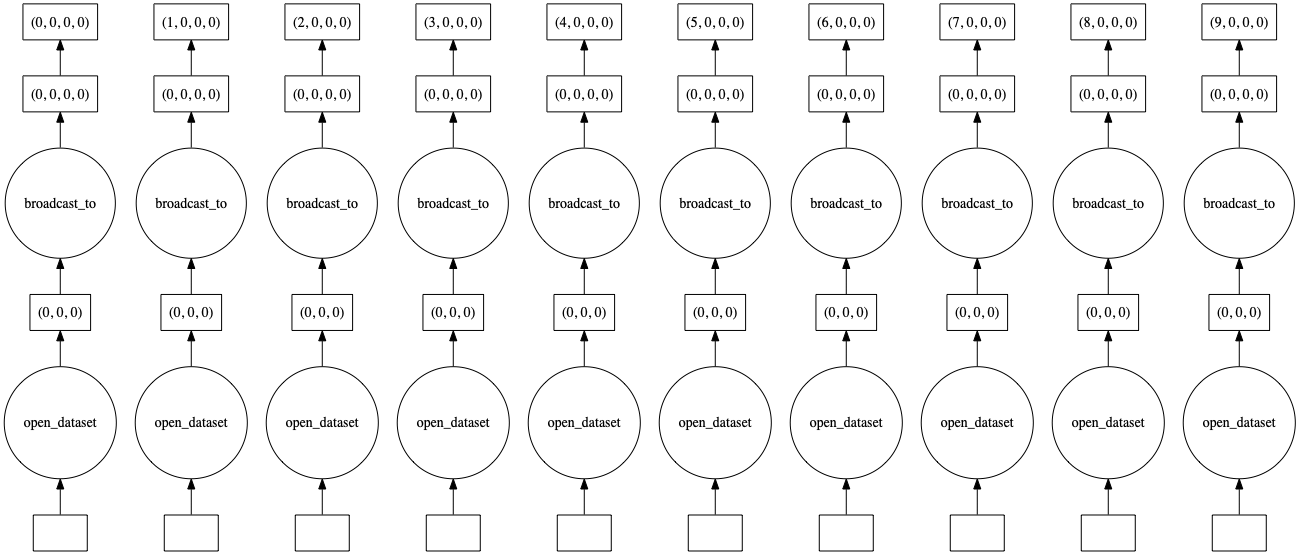

In [26]:
dset.air.data.visualize()

In [35]:
%%time
ds.groupby('time.year').mean(['time', 'member_id']).compute()

CPU times: user 258 ms, sys: 23.7 ms, total: 282 ms
Wall time: 439 ms


<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, year: 2)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * year     (year) int64 2013 2014
Data variables:
    air      (year, lat, lon) float32 259.4416 259.285 ... 297.01044 297.03726

In [36]:
%%time
dset.groupby('time.year').mean(['time', 'member_id']).compute()

CPU times: user 276 ms, sys: 26.3 ms, total: 302 ms
Wall time: 921 ms


<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, year: 2)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * year     (year) int64 2013 2014
Data variables:
    air      (year, lat, lon) float32 259.4416 259.285 ... 297.01044 297.03726

In [37]:
with performance_report(filename="dask-perf-report-native.html"):
    ds.groupby('time.year').mean(['time', 'member_id']).compute()

In [39]:
from IPython.display import HTML

In [41]:
display(HTML("dask-perf-report-native.html"))

In [38]:
with performance_report(filename="dask-perf-report-mounted.html"):
    dset.groupby('time.year').mean(['time', 'member_id']).compute()

In [42]:
display(HTML("dask-perf-report-mounted.html"))